# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.9.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)).

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(
    data_path="c3w4_lectures.txt",
    data_format="vowpal_wabbit",
    target_folder="c3w4t2",
    batch_size=100
)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [5]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model_artm = artm.ARTM(
    num_topics=T,
    topic_names=topic_names,
    class_ids={"text": 1, "author": 1},
    num_document_passes=1,
    reuse_theta=True,
    cache_theta=True,
    seed=123
)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [6]:
# Ваш код
dictionary = artm.Dictionary('myFirstDict')
dictionary.gather(batch_vectorizer.data_path)

model_artm.initialize('myFirstDict')

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [7]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name="top_text", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_author", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [8]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(
    name='SparsePhi',
    tau=1e5,
    dictionary=dictionary,
    class_ids='text',
    topic_names='bcg'
))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [9]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [10]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(
    name='SparsePhi2',
    tau=-1e5,
    dictionary=dictionary,
    class_ids='text',
    topic_names=topic_names[:29]
))

Выполните еще 15 проходов по коллекции.

In [11]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [12]:
# Ваш код
for topic_name in model_artm.topic_names:
    print(topic_name + ': ', end='\n')
    print('  ', end='')
    tokens = model_artm.score_tracker["top_text"].last_tokens
    for word in tokens[topic_name]:    
        print(word, end=' '),
    print()
    print('  ', end='')
    tokens = model_artm.score_tracker["top_author"].last_tokens
    for word in tokens[topic_name]:    
        print(word, end=' '),
    print()

sbj0: 
  культура женщина роль идентичность мужчина театр конфликт мать актер пьеса шаман дух метро женский гендерный 
  Ольга_Исупова Кирилл_Разлогов Алексей_Бартошевич Владимир_Миронов Валентина_Харитонова Мария_Шутова Марина_Бутовская Ахмет_Ярлыкапов Павел_Соколов Наталья_Харламенкова Дина_Гусейнова Александр_Васильев Митчел_Резник Денис_Загарин Павел_Тищенко 
sbj1: 
  клетка днк белок организм молекула ген биологический геном бактерия рнк молекулярный биология вирус последовательность иммунный 
  Евгений_Шеваль Константин_Северинов Михаил_Гельфанд Максим_Франк-Каменецкий Антон_Буздин Андрей_Цатурян Андрей_Летаров Сергей_Науменко Александр_Апт Роман_Ефремов Рафаэль_Арутюнян Леонид_Марголис Юрий_Панчин Юлия_Краус Филлип_Шарп 
sbj2: 
  данные компьютер университет программа трудность компьютерный алгоритм разработка профессор обучение компания анализ создание пользователь ошибка 
  Дмитрий_Рогозин Александр_Поддьяков Дмитрий_Ветров Станислав_Протасов Елена_Вишленкова Александр_Тормасо

  знание мир социологический предмет познание дисциплина контекст социолог логика аргумент восприятие научный описание интерпретация виктор 
  Виктор_Вахштайн Иван_Болдырев Ирина_Савельева Григорий_Крейдлин Сергей_Наугольных Екатерина_Протасова Наталья_Смолянская Василий_Жарков Зоригто_Намсараев Максим_Демин Юлия_Краус Татьяна_Котова Александр_Марков Андрей_Лукашов Мария_Падун 
sbj23: 
  язык текст предложение категория лингвист глагол филологический лингвистика перевод языковой грамматика английский падеж лингвистический конструкция 
  Владимир_Плунгян Андрей_Кибрик Кирилл_Бабаев Георгий_Старостин Владимир_Беликов Петр_Аркадьев Нина_Сумбатова Светлана_Бурлак Мира_Бергельсон Андрей_Лукашов Анна_Дыбо Анатолий_Баранов Максим_Кронгауз Екатерина_Лютикова Ирина_Левонтина 
sbj24: 
  внимание микроб пушкин след глаз микробный генеалогия сцена снорри скандинавский исландия яблоко норвегия стержень многоклеточный 
  Елизавета_Бонч-Осмоловская Фёдор_Успенский Алина_Бодрова Андрей_Иванцов Зоригто

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [13]:
sbj_topic_labels = [
    'Мужчина - Женщина',
    'Микробиология',
    'Пользователь - ошибка',
    'Старая мифология',
    'Русская литература',
    'Исследования, живодёрство',
    'Религия',
    'Актёрское мастерство',
    'Психология',
    'Всё подряд',
    'Индейцы и всё такое',
    'Основы химии',
    'Медицина',
    'Произношение',
    'Всё о памяти',
    'Кино и общество',
    'Великая Отечественная Война',
    'Физмат',
    'История',
    'Астрология',
    'Философия',
    'Недроведение',
    'Познание мира',
    'Языковедение',
    'Биология викингов',
    'Юриспруденция',
    'Французская революция',
    'Сети передачи данных',
    'Физика - Проводники'
]   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [14]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
phi_a = model_artm.get_phi(class_ids=['author'])
theta = model_artm.get_theta()

In [15]:
phi_a.head()

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
"(author, Максим_Киселев)",0.0,0.0,0.000000e+00,0.0,0.018796,0.0,0.0,0.0,1.567271e-16,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.004110
"(author, Мария_Полински)",0.0,0.0,2.848084e-16,0.0,0.000000,0.0,0.0,0.0,7.225158e-09,0.0,...,0.0,0.0,0.0,0.014490,0.0,0.0,0.0,0.0,0.000000,0.000005
"(author, Светлана_Бурлак)",0.0,0.0,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,0.043518,0.0,0.0,0.0,0.0,0.000000,0.000000
"(author, Харольд_Крото)",0.0,0.0,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.004940
"(author, Григорий_Кабатянский)",0.0,0.0,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.001653,0.000000


In [16]:
theta.head()

,http://postnauka.ru/video/50406,http://postnauka.ru/video/50407,http://postnauka.ru/video/50408,http://postnauka.ru/video/50656,http://postnauka.ru/video/50659,http://postnauka.ru/video/50665,http://postnauka.ru/video/50668,http://postnauka.ru/video/50670,http://postnauka.ru/video/50699,http://postnauka.ru/video/50701,...,http://postnauka.ru/video/31193,http://postnauka.ru/video/31196,http://postnauka.ru/video/31198,http://postnauka.ru/video/31200,http://postnauka.ru/video/31205,http://postnauka.ru/video/31207,http://postnauka.ru/video/31210,http://postnauka.ru/video/31213,http://postnauka.ru/video/31214,http://postnauka.ru/video/31219
sbj0,1.225565e-12,1.149330e-02,0.000000e+00,5.952357e-07,0.001562,0.000000e+00,3.249927e-03,2.435559e-03,1.334114e-07,2.059679e-13,...,0.000000e+00,4.585243e-10,0.000834,0.000000e+00,0.000000,2.907263e-07,0.000000,7.382718e-06,0.000000e+00,5.485446e-03
sbj1,8.541852e-08,1.300758e-09,2.614800e-06,0.000000e+00,0.000000,8.487134e-13,0.000000e+00,2.034244e-14,0.000000e+00,0.000000e+00,...,0.000000e+00,1.797558e-01,0.000000,2.478512e-03,0.152425,0.000000e+00,0.000000,0.000000e+00,8.564381e-16,0.000000e+00
sbj2,7.048600e-02,1.997586e-06,4.979666e-03,1.802679e-04,0.008260,3.048461e-04,3.374621e-08,9.952273e-03,5.245591e-07,4.137272e-08,...,5.967887e-10,1.457297e-15,0.115438,3.739985e-07,0.000000,1.371748e-01,0.000014,3.051311e-02,5.071730e-02,1.338998e-02
sbj3,2.950211e-06,2.048409e-10,1.418594e-09,1.244450e-06,0.000090,1.372933e-12,1.510164e-02,1.967898e-06,3.138519e-11,1.032880e-04,...,4.663655e-03,0.000000e+00,0.000000,0.000000e+00,0.000000,6.095296e-06,0.000000,2.726896e-14,0.000000e+00,3.472177e-07
sbj4,1.968356e-12,2.140757e-05,0.000000e+00,1.422414e-04,0.000020,0.000000e+00,5.800474e-03,7.600707e-09,4.473502e-16,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,1.031520e-16,0.000000,0.000000e+00,0.000000e+00,0.000000e+00


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

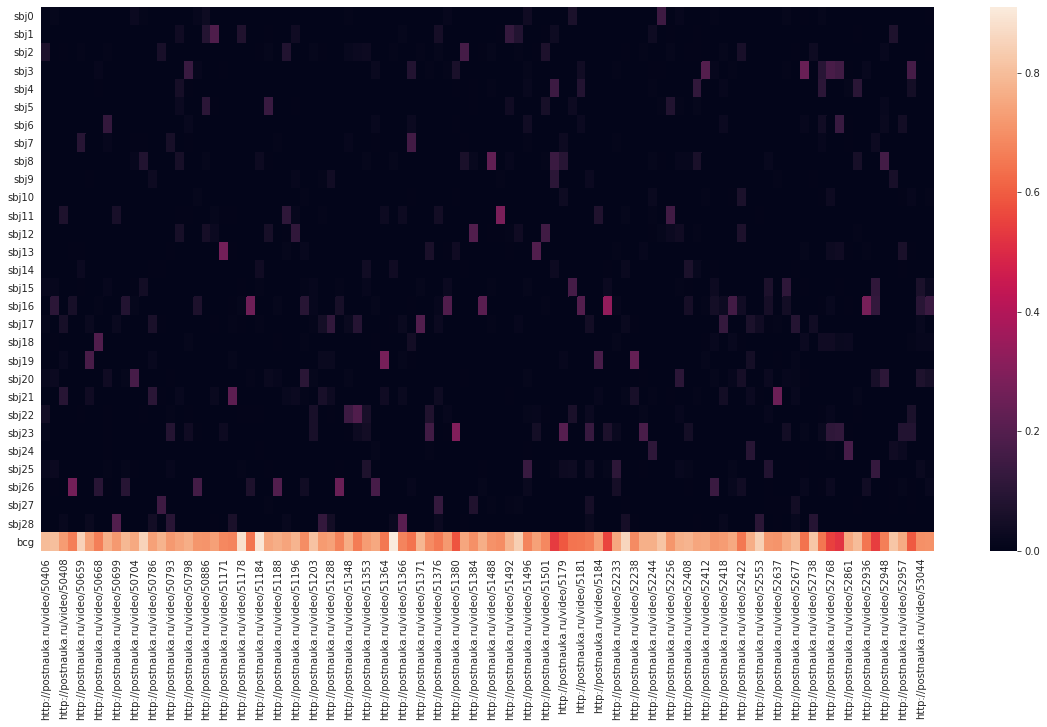

In [17]:
# Ваш код
plt.subplots(1, 1, figsize=[20, 10])
seaborn.heatmap(theta.iloc[:, :100])

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [18]:
# Ваш код
pt = pd.DataFrame(data=np.zeros(T), index=topic_names, columns=['p(t)'])

In [19]:
rowsSum = 0
for i in range(T):
    rowSum = np.sum(theta.iloc[i])
    rowsSum += rowSum
    idx = topic_names[i]
    pt['p(t)'][idx] = rowSum
pt = pt / rowsSum
pt

,p(t)
sbj0,0.007454
sbj1,0.017548
sbj2,0.010823
sbj3,0.010359
sbj4,0.004788
sbj5,0.006675
sbj6,0.012502
sbj7,0.005589
sbj8,0.013322
sbj9,0.009450


In [20]:
pt.sort_values('p(t)')

,p(t)
sbj24,0.002812
sbj14,0.003902
sbj27,0.004363
sbj4,0.004788
sbj10,0.004791
sbj13,0.005522
sbj7,0.005589
sbj5,0.006675
sbj0,0.007454
sbj9,0.009450


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [21]:
for label, name in zip (topic_labels, topic_names):
    print(name, label)

sbj0 Мужчина - Женщина
sbj1 Микробиология
sbj2 Пользователь - ошибка
sbj3 Старая мифология
sbj4 Русская литература
sbj5 Исследования, живодёрство
sbj6 Религия
sbj7 Актёрское мастерство
sbj8 Психология
sbj9 Всё подряд
sbj10 Индейцы и всё такое
sbj11 Основы химии
sbj12 Медицина
sbj13 Произношение
sbj14 Всё о памяти
sbj15 Кино и общество
sbj16 Великая Отечественная Война
sbj17 Физмат
sbj18 История
sbj19 Астрология
sbj20 Философия
sbj21 Недроведение
sbj22 Познание мира
sbj23 Языковедение
sbj24 Биология викингов
sbj25 Юриспруденция
sbj26 Французская революция
sbj27 Сети передачи данных
sbj28 Физика - Проводники
bcg Фоновая тема


Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

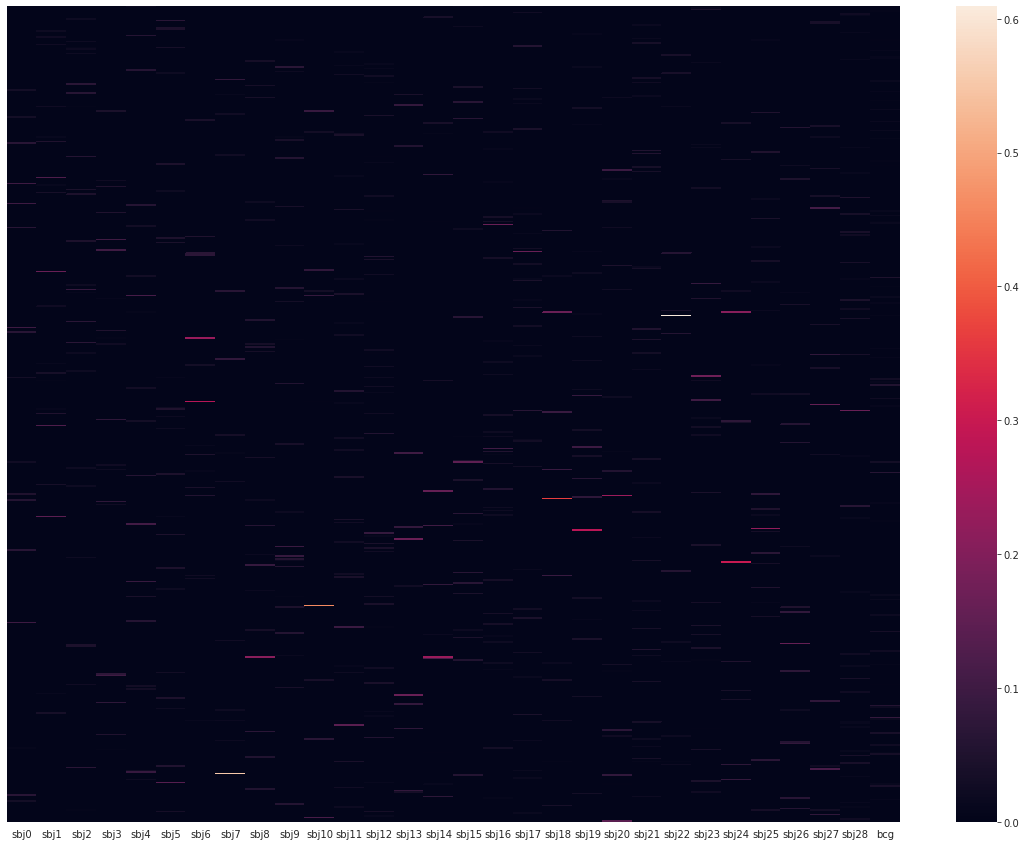

In [22]:
# Ваш код
plt.subplots(1,1,figsize=(20, 15))
seaborn.heatmap(phi_a, yticklabels=False)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [23]:
authorsCount = phi_a.shape[0]
authorsNames = [author[1] for author in phi_a.index]
authors = pd.DataFrame(data=np.zeros([authorsCount, 2]), index=authorsNames, columns=['topics_count', '3_or_more'])

for i in range(authorsCount):
    topicsCount = np.sum([1 if value > 0.01 else 0 for value in phi_a.iloc[i]])
    authors['topics_count'][authorsNames[i]] = topicsCount
    authors['3_or_more'][authorsNames[i]] = topicsCount >= 3
authors

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,topics_count,3_or_more
Максим_Киселев,2.0,False
Мария_Полински,1.0,False
Светлана_Бурлак,1.0,False
Харольд_Крото,0.0,False
Григорий_Кабатянский,1.0,False
...,...,...
Константин_Лукьянов,1.0,False
Александр_Шварцбург,1.0,False
Андрей_Журавлев,1.0,False
Владимир_Польшаков,1.0,False


In [24]:
for author in authors.iloc:
    if author['3_or_more']:
        print(author)

topics_count       3
3_or_more       True
Name: Владимир_Шалаев, dtype: object
topics_count       3
3_or_more       True
Name: Раиса_Кирсанова, dtype: object
topics_count       3
3_or_more       True
Name: Александр_Васильев, dtype: object
topics_count       3
3_or_more       True
Name: Виталий_Куренной, dtype: object
topics_count       3
3_or_more       True
Name: Андрей_Виноградов, dtype: object


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [25]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [26]:
# Ваш код
pta = pd.DataFrame(data=np.zeros([authorsCount, T]), index=authorsNames, columns=topic_names)
sumpatpt = pd.DataFrame(data=np.zeros(authorsCount), index=authorsNames, columns=['sum'])

In [27]:
for i in range(authorsCount):
    sum = 0
    for j in range(T):
        sum += phi_a.iloc[i,j] * pt.iloc[j, 0]
    sumpatpt.iloc[i] = sum

In [28]:
for i in range(authorsCount):
    for j in range(T):
        pta.iloc[i,j] = phi_a.iloc[i,j] * pt.iloc[j, 0] / sumpatpt.iloc[i, 0]

In [29]:
distances = pairwise_distances(pta, metric='cosine')

mds = MDS(n_components = 2 , dissimilarity='precomputed')
pta_2d = mds.fit_transform(distances)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

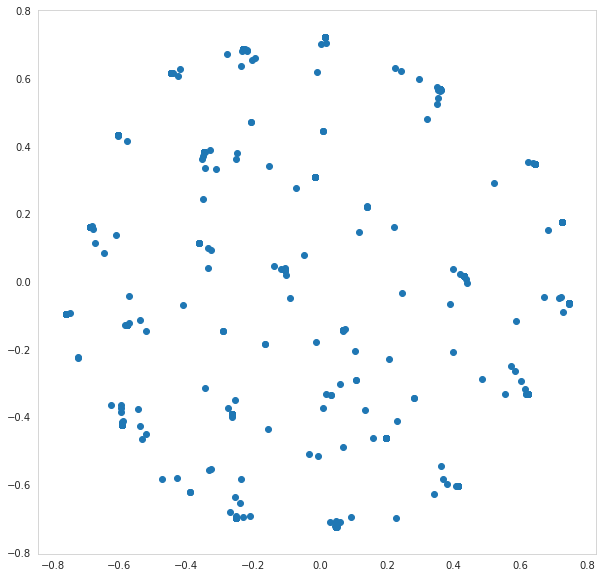

In [30]:
# Ваш код
plt.figure(figsize=(10, 10))
plt.scatter(pta_2d[:, 0], pta_2d[:, 1])

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

In [31]:
import matplotlib.cm as cm
colors = pd.DataFrame(data=cm.rainbow(np.linspace(0, 1, T)), index=topic_names) # цвета для тем
# Ваш код

In [32]:
ptaColor = []
for i in range(authorsCount):
    colorIdx = pta.columns[[np.max(pta.iloc[i]) == value for value in pta.iloc[i]]]
    colorValue = colors.loc[colorIdx]
    ptaColor.append(colorValue.to_numpy()[0])

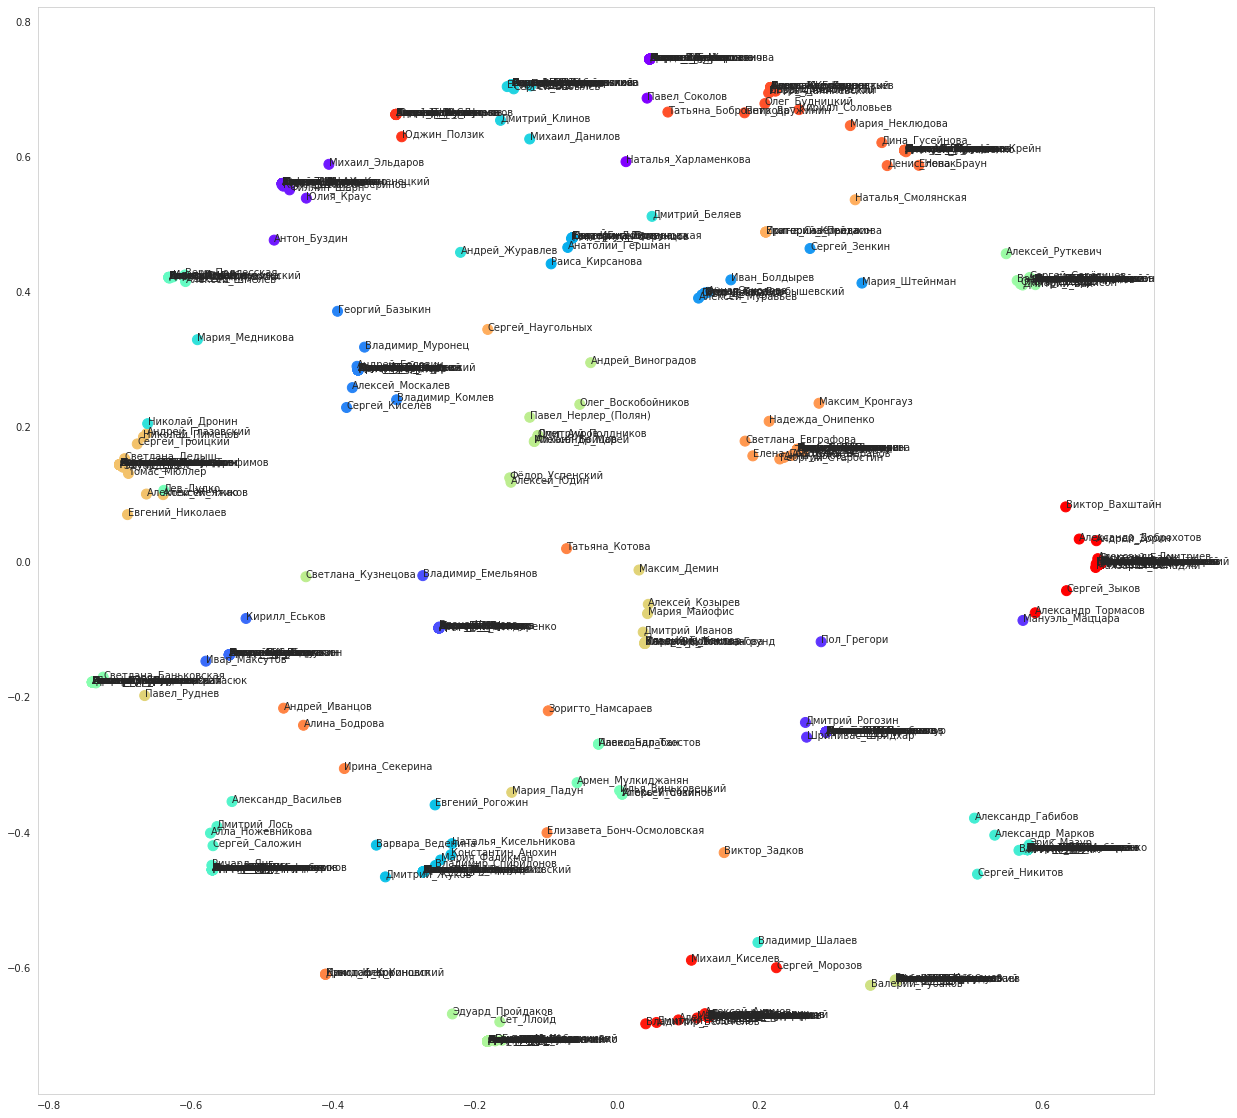

In [33]:
plt.figure(figsize=(20,20))
plt.scatter(pta_2d[:, 0], pta_2d[:, 1], s=100, c=ptaColor)

for i in range(authorsCount):
    coords = pta_2d[i]
    plt.annotate(pta.index[i], xy=coords)
    
plt.savefig('c3w4t2_map.pdf')

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [33]:
# Ваш код
pdt = pd.DataFrame(data=np.zeros(theta.shape), index=theta.index, columns=theta.columns)

for i in range(theta.index.size):
    rowSum = np.sum(theta.iloc[i])
    for j in range(theta.columns.size):
        pdt.iloc[i,j] = theta.iloc[i,j] / rowsSum

In [34]:
pdtSorted = []
for i in range(pdt.index.size):
    pdtSorted.append(pdt.iloc[i, pdt.iloc[i, :].argsort()])

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [35]:
print("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [36]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [39]:
# Ваш код
tokens = model_artm.score_tracker["top_text"].last_tokens

for i in range(np.size(topic_labels)):
    themeName = topic_labels[i]
    display(HTML('<h1>' + themeName + '</h1>'))

    wordsRow = ''
    for word in tokens[topic_names[i]]:    
        wordsRow += word + ', '
    display(HTML('<p>'+ wordsRow + '</p>'))

    links = pdtSorted[i].index[-10:]
    for j in range(9, -1, -1):
        print(links[j])

http://postnauka.ru/video/12740
http://postnauka.ru/video/23470
http://postnauka.ru/video/24279
http://postnauka.ru/video/6377
http://postnauka.ru/video/27848
http://postnauka.ru/video/20388
http://postnauka.ru/video/36707
http://postnauka.ru/video/48621
http://postnauka.ru/video/26223
http://postnauka.ru/video/48624


http://postnauka.ru/video/17051
http://postnauka.ru/video/37537
http://postnauka.ru/video/11628
http://postnauka.ru/video/59451
http://postnauka.ru/video/44252
http://postnauka.ru/video/15043
http://postnauka.ru/video/35051
http://postnauka.ru/video/6477
http://postnauka.ru/video/3615
http://postnauka.ru/video/43381


http://postnauka.ru/video/45717
http://postnauka.ru/video/24306
http://postnauka.ru/video/32901
http://postnauka.ru/video/45719
http://postnauka.ru/video/3635
http://postnauka.ru/video/46341
http://postnauka.ru/video/33885
http://postnauka.ru/video/55303
http://postnauka.ru/video/49448
http://postnauka.ru/video/50349


http://postnauka.ru/video/53171
http://postnauka.ru/video/54238
http://postnauka.ru/video/47300
http://postnauka.ru/video/17058
http://postnauka.ru/video/59201
http://postnauka.ru/video/56302
http://postnauka.ru/video/54849
http://postnauka.ru/video/52694
http://postnauka.ru/video/58759
http://postnauka.ru/video/57535


http://postnauka.ru/video/9429
http://postnauka.ru/video/11034
http://postnauka.ru/video/26207
http://postnauka.ru/video/23111
http://postnauka.ru/video/48335
http://postnauka.ru/video/21637
http://postnauka.ru/video/37968
http://postnauka.ru/video/10779
http://postnauka.ru/video/7767
http://postnauka.ru/video/50097


http://postnauka.ru/video/5915
http://postnauka.ru/video/31671
http://postnauka.ru/video/17416
http://postnauka.ru/video/28587
http://postnauka.ru/video/43853
http://postnauka.ru/video/1817
http://postnauka.ru/video/22764
http://postnauka.ru/video/27925
http://postnauka.ru/video/43384
http://postnauka.ru/video/7713


http://postnauka.ru/video/3387
http://postnauka.ru/video/49203
http://postnauka.ru/video/17397
http://postnauka.ru/video/10751
http://postnauka.ru/video/48959
http://postnauka.ru/video/50071
http://postnauka.ru/video/31707
http://postnauka.ru/video/9855
http://postnauka.ru/video/12738
http://postnauka.ru/video/46313


http://postnauka.ru/video/1893
http://postnauka.ru/video/12290
http://postnauka.ru/video/55724
http://postnauka.ru/video/57126
http://postnauka.ru/video/5999
http://postnauka.ru/video/7218
http://postnauka.ru/video/24461
http://postnauka.ru/video/31228
http://postnauka.ru/video/55068
http://postnauka.ru/video/3637


http://postnauka.ru/video/25101
http://postnauka.ru/video/9865
http://postnauka.ru/video/24451
http://postnauka.ru/video/51488
http://postnauka.ru/video/7782
http://postnauka.ru/video/23829
http://postnauka.ru/video/5465
http://postnauka.ru/video/25267
http://postnauka.ru/video/32632
http://postnauka.ru/video/45295


http://postnauka.ru/video/12971
http://postnauka.ru/video/12515
http://postnauka.ru/video/13742
http://postnauka.ru/video/35065
http://postnauka.ru/video/46562
http://postnauka.ru/video/12375
http://postnauka.ru/video/24286
http://postnauka.ru/video/32635
http://postnauka.ru/video/26616
http://postnauka.ru/video/27938


http://postnauka.ru/video/31705
http://postnauka.ru/video/46317
http://postnauka.ru/video/49866
http://postnauka.ru/video/44729
http://postnauka.ru/video/44273
http://postnauka.ru/video/22332
http://postnauka.ru/video/31679
http://postnauka.ru/video/44730
http://postnauka.ru/video/12576
http://postnauka.ru/video/6562


http://postnauka.ru/video/13700
http://postnauka.ru/video/31182
http://postnauka.ru/video/13544
http://postnauka.ru/video/48107
http://postnauka.ru/video/51490
http://postnauka.ru/video/41686
http://postnauka.ru/video/46379
http://postnauka.ru/video/31682
http://postnauka.ru/video/18048
http://postnauka.ru/video/56295


http://postnauka.ru/video/13746
http://postnauka.ru/video/2541
http://postnauka.ru/video/12974
http://postnauka.ru/video/11361
http://postnauka.ru/video/532
http://postnauka.ru/video/7113
http://postnauka.ru/video/16821
http://postnauka.ru/video/49206
http://postnauka.ru/video/45961
http://postnauka.ru/video/17049


http://postnauka.ru/video/48114
http://postnauka.ru/video/10773
http://postnauka.ru/video/51171
http://postnauka.ru/video/36272
http://postnauka.ru/video/40001
http://postnauka.ru/video/8964
http://postnauka.ru/video/51499
http://postnauka.ru/video/14284
http://postnauka.ru/video/56829
http://postnauka.ru/video/40870


http://postnauka.ru/video/56052
http://postnauka.ru/video/57336
http://postnauka.ru/video/54916
http://postnauka.ru/video/37979
http://postnauka.ru/video/27845
http://postnauka.ru/video/56050
http://postnauka.ru/video/48962
http://postnauka.ru/video/53949
http://postnauka.ru/video/10783
http://postnauka.ru/video/57318


http://postnauka.ru/video/9870
http://postnauka.ru/video/9150
http://postnauka.ru/video/6497
http://postnauka.ru/video/20394
http://postnauka.ru/video/11642
http://postnauka.ru/video/24945
http://postnauka.ru/video/25097
http://postnauka.ru/video/13546
http://postnauka.ru/video/2530
http://postnauka.ru/video/13744


http://postnauka.ru/video/9997
http://postnauka.ru/video/19574
http://postnauka.ru/video/36581
http://postnauka.ru/video/13152
http://postnauka.ru/video/12148
http://postnauka.ru/video/7778
http://postnauka.ru/video/5198
http://postnauka.ru/video/31183
http://postnauka.ru/video/7283
http://postnauka.ru/video/22087


http://postnauka.ru/video/11651
http://postnauka.ru/video/3388
http://postnauka.ru/video/7311
http://postnauka.ru/video/19456
http://postnauka.ru/video/55069
http://postnauka.ru/video/18086
http://postnauka.ru/video/43677
http://postnauka.ru/video/2520
http://postnauka.ru/video/58741
http://postnauka.ru/video/57128


http://postnauka.ru/video/3348
http://postnauka.ru/video/10477
http://postnauka.ru/video/9968
http://postnauka.ru/video/28942
http://postnauka.ru/video/23472
http://postnauka.ru/video/24030
http://postnauka.ru/video/31677
http://postnauka.ru/video/24034
http://postnauka.ru/video/42999
http://postnauka.ru/video/42087


http://postnauka.ru/video/31193
http://postnauka.ru/video/2971
http://postnauka.ru/video/17780
http://postnauka.ru/video/17779
http://postnauka.ru/video/6673
http://postnauka.ru/video/58574
http://postnauka.ru/video/31695
http://postnauka.ru/video/48109
http://postnauka.ru/video/57338
http://postnauka.ru/video/36249


http://postnauka.ru/video/31219
http://postnauka.ru/video/11626
http://postnauka.ru/video/9728
http://postnauka.ru/video/45548
http://postnauka.ru/video/37996
http://postnauka.ru/video/43680
http://postnauka.ru/video/40882
http://postnauka.ru/video/50347
http://postnauka.ru/video/10788
http://postnauka.ru/video/47551


http://postnauka.ru/video/25875
http://postnauka.ru/video/19509
http://postnauka.ru/video/23776
http://postnauka.ru/video/24245
http://postnauka.ru/video/15049
http://postnauka.ru/video/9835
http://postnauka.ru/video/57638
http://postnauka.ru/video/52637
http://postnauka.ru/video/26665
http://postnauka.ru/video/23890


http://postnauka.ru/video/17488
http://postnauka.ru/video/7763
http://postnauka.ru/video/51350
http://postnauka.ru/video/2531
http://postnauka.ru/video/5517
http://postnauka.ru/video/11640
http://postnauka.ru/video/17486
http://postnauka.ru/video/35038
http://postnauka.ru/video/22883
http://postnauka.ru/video/434


http://postnauka.ru/video/9692
http://postnauka.ru/video/2957
http://postnauka.ru/video/3625
http://postnauka.ru/video/13041
http://postnauka.ru/video/7525
http://postnauka.ru/video/7755
http://postnauka.ru/video/4280
http://postnauka.ru/video/3646
http://postnauka.ru/video/51380
http://postnauka.ru/video/22433


http://postnauka.ru/video/53228
http://postnauka.ru/video/52861
http://postnauka.ru/video/49595
http://postnauka.ru/video/21660
http://postnauka.ru/video/38508
http://postnauka.ru/video/41192
http://postnauka.ru/video/40004
http://postnauka.ru/video/52244
http://postnauka.ru/video/44271
http://postnauka.ru/video/46933


http://postnauka.ru/video/13042
http://postnauka.ru/video/17913
http://postnauka.ru/video/38009
http://postnauka.ru/video/31688
http://postnauka.ru/video/16822
http://postnauka.ru/video/10749
http://postnauka.ru/video/12371
http://postnauka.ru/video/34414
http://postnauka.ru/video/3602
http://postnauka.ru/video/42221


http://postnauka.ru/video/36246
http://postnauka.ru/video/35041
http://postnauka.ru/video/41671
http://postnauka.ru/video/29992
http://postnauka.ru/video/32637
http://postnauka.ru/video/42809
http://postnauka.ru/video/53577
http://postnauka.ru/video/54175
http://postnauka.ru/video/50656
http://postnauka.ru/video/49453


http://postnauka.ru/video/47810
http://postnauka.ru/video/25902
http://postnauka.ru/video/50792
http://postnauka.ru/video/26228
http://postnauka.ru/video/33771
http://postnauka.ru/video/56281
http://postnauka.ru/video/51376
http://postnauka.ru/video/39997
http://postnauka.ru/video/32918
http://postnauka.ru/video/10754


http://postnauka.ru/video/24434
http://postnauka.ru/video/22760
http://postnauka.ru/video/33795
http://postnauka.ru/video/27835
http://postnauka.ru/video/55538
http://postnauka.ru/video/26609
http://postnauka.ru/video/22314
http://postnauka.ru/video/54745
http://postnauka.ru/video/26515
http://postnauka.ru/video/6726


http://postnauka.ru/video/51365
http://postnauka.ru/video/51184
http://postnauka.ru/video/49851
http://postnauka.ru/video/51178
http://postnauka.ru/video/42436
http://postnauka.ru/video/45460
http://postnauka.ru/video/46943
http://postnauka.ru/video/45956
http://postnauka.ru/video/43669
http://postnauka.ru/video/54668


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 